In [1]:
import os
import pathlib

# Set the working directory to be the parent of the cwd
os.chdir(pathlib.Path(os.getcwd()).parent)
cwd = os.getcwd()
print(cwd)

c:\Users\gipop\Desktop\Bocconi\4-Courses\20878-ComputerVision\21-eyes


## Imports

In [2]:

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchsummary import summary
import torchvision
from utils import CustomDataset
import wandb
import yaml
from yolo_functions import compute_loss

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

Device: cpu


## Configuration dictionaries

In [3]:
YOLO_PARAMS = {
    "S": 7, # Grid cells
    "B": 2, # Bounding boxes per each cell
    "C": 52 # Classes
}
OUTPUT_SIZE = YOLO_PARAMS["S"]*YOLO_PARAMS["S"] * (YOLO_PARAMS["B"]*5 + YOLO_PARAMS["C"])


convolution_list = [
    {
        "in_c": 3,
        "channels": [64],
        "kernels": [7],
        "strides": [2],
        "pool": [2, 2]
    },
    {
        "in_c": 64,
        "channels": [192],
        "kernels": [3],
        "strides": [1],
        "pool": [2, 2]
    },
    {
        "in_c": 192,
        "channels": [128, 256, 256, 512],
        "kernels": [1, 3, 1, 3],
        "strides": [1, 1, 1, 1],
        "pool": [2, 2]
    },
    {
        "in_c": 512,
        "channels": [256, 512]*4 + [512, 1024],
        "kernels": [1, 3]*4 + [1, 3],
        "strides": [1, 1]*4 + [1, 1],
        "pool": [2, 2]
    },
    {
        "in_c": 1024,
        "channels": [512, 1024]*2 + [1024, 1024],
        "kernels": [1, 3]*2 + [3, 3],
        "strides": [1, 1]*2 + [1, 2],
        "pool": False
    },
    {
        "in_c": 1024,
        "channels": [1024, 1024],
        "kernels": [3, 3],
        "strides": [1, 1],
        "pool": False
    },
]


mlp_dict = {
    "in_size": 1024,
    "hidden_sizes": [4096],
    "out_size": OUTPUT_SIZE
}

In [4]:
CONFIG = {
    "architecture"  : "yoloV1",
    "batch_size"    : 64,
    "epochs"        : 50,
    "lr"            : 5e-3,
    "optimizer"     : "SGD",
    "momentum"      : 0.9,
    "weight_decay"  : 0.0005,
    "p_dropout"     : 0.5,
    "scheduler"     : "ReduceLROnPlateau",
}

## Datasets and dataloaders

In [5]:
classes_path = os.path.join("configurations", "classes.yaml")
with open(classes_path, "r") as f:
    classes_yaml = yaml.safe_load(f)

CLASSES = classes_yaml["classes"]
NUM_CLASSES = len(CLASSES)

In [6]:
train_data = CustomDataset(
    images_dir=os.path.join(cwd, "data", "train", "images"),
    labels_dir=os.path.join(cwd, "data", "train", "labels"),
    classes=CLASSES,
    yolo_params=YOLO_PARAMS,
    transform=None,
    input_size=(448, 448)
)

train_loader = DataLoader(
    dataset=train_data,
    batch_size=CONFIG["batch_size"],
    num_workers=8,
    shuffle=True,
    pin_memory=True
)

development_data = CustomDataset(
    images_dir=os.path.join(cwd, "data", "development", "images"),
    labels_dir=os.path.join(cwd, "data", "development", "labels"),
    classes=CLASSES,
    yolo_params=YOLO_PARAMS,
    transform=None,
    input_size=(448, 448)
)

development_loader = DataLoader(
    dataset=development_data,
    batch_size=CONFIG["batch_size"],
    num_workers=8,
    shuffle=False
)

# TODO: Load the test data

### Check

In [7]:
for i, (batch, batch_label) in enumerate(train_loader):
    img = batch[0]
    label = batch_label[0]
    print(f"Image shape: {img.shape}")
    print(f"Label shape: {label.shape}")
    print(f"Batch: {batch.shape[0]}")
    break

Image shape: torch.Size([3, 416, 416])
Label shape: torch.Size([7, 7, 62])
Batch: 64


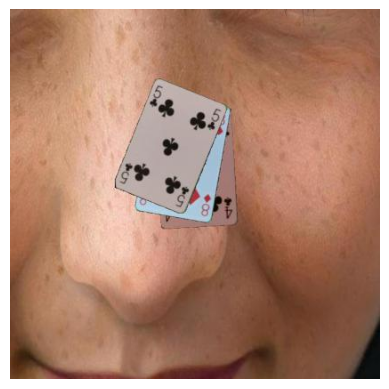

In [8]:
plt.imshow(img.permute(1, 2, 0).numpy())
plt.axis("off")
plt.show()

## Architecture

In [9]:
class ConvolutionBlock(nn.Module):

    def __init__(self, in_c, channels, kernels, strides, pool):
        super(ConvolutionBlock, self).__init__()

        convolutions = [nn.Conv2d(
            in_channels=in_c,
            out_channels=channels[0],
            kernel_size=kernels[0],
            stride=strides[0],
            padding=kernels[0]//2
            ),
            nn.LeakyReLU(negative_slope=0.1)
        ]
        if len(channels) > 1:
            for i in range(len(channels)-1):
                convolutions.append(nn.Conv2d(
                in_channels=channels[i],
                out_channels=channels[i+1],
                kernel_size=kernels[i+1],
                stride=strides[i+1],
                padding=kernels[i+1]//2
                ))
                convolutions.append(nn.LeakyReLU(negative_slope=0.1))
        
        if pool:
            convolutions.append(nn.MaxPool2d(
            kernel_size=pool[0],
            stride=pool[1]
            ))

        self.convolutions = nn.Sequential(*convolutions)


    def forward(self, x):
        return self.convolutions(x)

In [10]:
class Mlp(nn.Module):

    def __init__(self, in_size, hidden_sizes, out_size):
        super(Mlp, self).__init__()

        fully_connected = [
            nn.Linear(
                in_features=in_size,
                out_features=hidden_sizes[0]
            ),
            nn.LeakyReLU(negative_slope=0.1)
        ]
        
        if len(hidden_sizes) > 1:
            for i in range(len(hidden_sizes)-1):
                fully_connected.append(nn.Linear(
                    in_features=hidden_sizes[i],
                    out_features=hidden_sizes[i+1]
                ))
                fully_connected.append(nn.LeakyReLU(negative_slope=0.1))

        fully_connected.append(nn.Linear(
            in_features=hidden_sizes[-1],
            out_features=out_size
        ))

        self.fully_connected = nn.Sequential(*fully_connected)
    
    
    def forward(self, x):
        return self.fully_connected(x)

In [11]:
class YoloV1(nn.Module):

    def __init__(self, yolo_params, convolution_blocks, mlp):
        super(YoloV1, self).__init__()

        self.params = yolo_params
        self.convolutions = nn.ModuleList(
            [
                ConvolutionBlock(
                    in_c=block["in_c"],
                    channels=block["channels"],
                    kernels=block["kernels"],
                    strides=block["strides"],
                    pool=block["pool"]
                ) for block in convolution_blocks
            ]
        )

        self.pool_flatten = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten()
        )

        self.mlp = mlp
    
    
    def forward(self, x):
        for conv in self.convolutions:
            x = conv(x)
        x = self.pool_flatten(x)
        x = self.mlp(x)
        x = x.view(-1, self.params["S"], self.params["S"], self.params["B"]*5 + self.params["C"])

        return x

In [12]:
yolo_v1 = YoloV1(
    yolo_params=YOLO_PARAMS,
    convolution_blocks=convolution_list,
    mlp=Mlp(
        in_size=mlp_dict["in_size"],
        hidden_sizes= mlp_dict["hidden_sizes"],
        out_size=mlp_dict["out_size"]
    )
).to(DEVICE)

summary(yolo_v1, (3, 416, 416), device=DEVICE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 208, 208]           9,472
         LeakyReLU-2         [-1, 64, 208, 208]               0
         MaxPool2d-3         [-1, 64, 104, 104]               0
  ConvolutionBlock-4         [-1, 64, 104, 104]               0
            Conv2d-5        [-1, 192, 104, 104]         110,784
         LeakyReLU-6        [-1, 192, 104, 104]               0
         MaxPool2d-7          [-1, 192, 52, 52]               0
  ConvolutionBlock-8          [-1, 192, 52, 52]               0
            Conv2d-9          [-1, 128, 52, 52]          24,704
        LeakyReLU-10          [-1, 128, 52, 52]               0
           Conv2d-11          [-1, 256, 52, 52]         295,168
        LeakyReLU-12          [-1, 256, 52, 52]               0
           Conv2d-13          [-1, 256, 52, 52]          65,792
        LeakyReLU-14          [-1, 256,

In [89]:
optimizer = torch.optim.SGD(
    params=yolo_v1.parameters(),
    lr=CONFIG["lr"],
    momentum=CONFIG["momentum"],
    weight_decay=CONFIG["weight_decay"]
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer,
    mode="min",
    threshold=0.1,
    factor=0.5,
    patience=5,
)

scaler = torch.amp.GradScaler("cuda")

c:\Users\gipop\Desktop\Bocconi\4-Courses\20878-ComputerVision\21-eyes\.venv-21-eyes\Lib\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


- Add padding to images to get shape 448x448

In [13]:
y = yolo_v1(batch.to(DEVICE))

In [78]:
def compute_iou(box1_center, box1_size, box2_center, box2_size):
    
    box1_min = box1_center - box1_size/2
    box1_max = box1_center + box1_size/2
    box2_min = box2_center - box2_size/2
    box2_max = box2_center + box2_size/2

    # Intersection area
    inter_min = torch.max(box1_min, box2_min)
    inter_max = torch.min(box1_max, box2_max)
    inter_area = torch.clamp(inter_max - inter_min, min=0)
    inter_area = inter_area.prod(dim=-1)

    # Union area
    box1_area = box1_size.prod(dim=-1)
    box2_area = box2_size.prod(dim=-1)
    union_area = box1_area + box2_area - inter_area

    # IoU
    iou = inter_area/(union_area+1e-5)
    return iou

In [83]:
lambda_coord = 5.0
lambda_noobj = 0.5

pred = y[0][torch.newaxis, ...].to(DEVICE)
print(pred.shape)
true = label[torch.newaxis, ...].to(DEVICE)
print(true.shape)

yolo_params = YOLO_PARAMS
S = yolo_params["S"]
B = yolo_params["B"]


batch_size = pred.size(0)

torch.Size([1, 7, 7, 62])
torch.Size([1, 7, 7, 62])


In [85]:
# Get a mask for the position of the object in the grid cell
# This is specific to YOLOv1, as if an object falls into a grid cell, that cell is responsible for predicting it
object_mask = true[..., 4]
print(object_mask.shape)

# Get the true box coordinates and dimensions
true_box_center = true[..., 0:2]
true_box_size = true[..., 2:4]

coord_loss = 0.0
confidence_loss_obj = 0.0
confidence_loss_noobj = 0.0

box_mask = torch.zeros(S, S, B)[torch.newaxis, ...].to(DEVICE)
ious = torch.zeros(S, S, B)[torch.newaxis, ...].to(DEVICE)
box_losses = torch.zeros(S, S, B)[torch.newaxis, ...].to(DEVICE)
noobj_loss = torch.zeros(S, S, B)[torch.newaxis, ...].to(DEVICE)
class_loss = torch.zeros(S, S)[torch.newaxis, ...].to(DEVICE)

for b in range(B):
    pred_box_center = pred[..., b*5:b*5+2]
    pred_box_size = pred[..., b*5+2:b*5+4]
    pred_confidence = pred[..., b*5+4]

    # 1. Compute the coordinate loss for the cells that contain an object
    loss_center = torch.sum((true_box_center-pred_box_center)**2, dim=-1)
    print("loss_center shape:", loss_center.shape)
    loss_size = torch.sum((torch.sqrt(true_box_size) - torch.sqrt(torch.clamp(pred_box_size, 1e-6)))**2, dim=-1)
    print("loss size shape:", loss_size.shape)
    # loss_masked = object_mask * (loss_center+loss_size)
    # coord_loss += lambda_coord * torch.sum(loss_masked, dim=-1, keepdim=True)
    box_losses[..., b] += lambda_coord * (loss_center+loss_size)
    print("box losses shape:", box_losses.shape)

    # 2. Compute the IoU for the predicted and true boxes and then the confidence loss for the cells that contain an object
    iou = compute_iou(pred_box_center, pred_box_size, true_box_center, true_box_size)
    # confidence_loss_obj += object_mask * torch.sum((iou-pred_confidence)**2, dim=-1, keepdim=True)
    box_losses[..., b] += (iou-pred_confidence)**2
    print(box_losses.shape)

    # 3. Compute the confidence loss for the cells that do not contain an object
    noobj_loss[..., b] += lambda_noobj * (iou-pred_confidence)**2
    print(noobj_loss.shape)
    # confidence_loss_noobj += lambda_noobj * (1-object_mask) * torch.sum((pred_confidence)**2, dim=-1, keepdim=True)
    # print(confidence_loss_obj.shape)

    ious[..., b] = iou

# create a box mask, which is a tensor of shape (1, S, S, B) with 1s where the IoU is the highest for each cell
box_mask = torch.zeros(S, S, B)[torch.newaxis, ...].to(DEVICE)
for b in range(B):
    box_mask[..., b] = (ious == ious.max(dim=-1))
print("box mask shape:", box_mask.shape)
print(box_mask)

coord_loss = torch.sum(box_mask*box_losses, dim=[1, 2, 3])
print("coord loss shape:", coord_loss.shape)
noobj_loss = torch.sum((1-box_mask) * noobj_loss, dim=[1, 2, 3])
print("noobj loss shape:", noobj_loss.shape)

class_loss = torch.sum((true[..., B*5:]-pred[..., B*5:])**2, dim=-1)
confidence_loss = torch.sum(object_mask*class_loss, dim=[1, 2])
print("confidence loss shape:", confidence_loss.shape)
    
# Average the losses
total_loss = torch.mean(coord_loss + noobj_loss + confidence_loss)
print(total_loss.item())



# # 4. Compute the classification loss
# print(class_loss.shape)


    # loss_center = torch.sum((true_box_center-pred_box_center)**2, dim=-1, keepdim=True)
    # print("loss_center shape:", loss_center.shape)

torch.Size([1, 7, 7])
loss_center shape: torch.Size([1, 7, 7])
loss size shape: torch.Size([1, 7, 7])
box losses shape: torch.Size([1, 7, 7, 2])
torch.Size([1, 7, 7, 2])
torch.Size([1, 7, 7, 2])
loss_center shape: torch.Size([1, 7, 7])
loss size shape: torch.Size([1, 7, 7])
box losses shape: torch.Size([1, 7, 7, 2])
torch.Size([1, 7, 7, 2])
torch.Size([1, 7, 7, 2])
box mask shape: torch.Size([1, 7, 7, 2])
tensor([[[[0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
   

In [76]:
pred_classes = pred[..., :52]  # Class probabilities
pred_boxes = pred[..., 52:52+2*5].reshape(-1, 7, 7, 2, 5)
# Each box has (x, y, w, h, confidence)
pred_x = pred_boxes[..., 0]
pred_y = pred_boxes[..., 1]
pred_w = pred_boxes[..., 2]
pred_h = pred_boxes[..., 3]
pred_conf = pred_boxes[..., 4]

# Split true into components
target_classes = true[..., :52]
target_boxes = true[..., 52:52+2*5].reshape(-1, 7, 7, 2, 5)
target_x = target_boxes[..., 0]
target_y = target_boxes[..., 1]
target_w = target_boxes[..., 2]
target_h = target_boxes[..., 3]
target_conf = target_boxes[..., 4]

# Create mask for cells that contain objects
obj_mask = target_conf > 0  # Shape: (1, S, S, B)
noobj_mask = target_conf == 0  # Shape: (1, S, S, B)

# For multiple bounding boxes per cell, we need to find the one with
# the highest IOU with the ground truth
obj_mask_expanded = obj_mask.unsqueeze(-1).expand(-1, -1, -1, -1, 4)  # For x, y, w, h

# 1. Localization Loss (coordinate prediction loss)
# Only penalize bounding box predictors responsible for detecting objects
xy_loss = lambda_coord * torch.sum(
    obj_mask * (
        (pred_x - target_x) ** 2 + (pred_y - target_y) ** 2
    )
)

# For width and height, use square root as per the paper
wh_loss = lambda_coord * torch.sum(
    obj_mask * (
        (torch.sqrt(pred_w + 1e-6) - torch.sqrt(target_w + 1e-6)) ** 2 +
        (torch.sqrt(pred_h + 1e-6) - torch.sqrt(target_h + 1e-6)) ** 2
    )
)

# 2. Object Confidence Loss (for cells with objects)
obj_conf_loss = torch.sum(
    obj_mask * (pred_conf - target_conf) ** 2
)

# 3. No Object Confidence Loss (for cells without objects)
noobj_conf_loss = lambda_noobj * torch.sum(
    noobj_mask * (pred_conf - target_conf) ** 2
)

# 4. Class Probability Loss (only for cells with objects)
# In YOLOv1, each grid cell predicts C class probabilities
# We need to find cells with objects
cell_has_obj_mask = torch.max(obj_mask, dim=3)[0]  # Shape: (1, S, S)
class_loss = torch.sum(
    cell_has_obj_mask.unsqueeze(-1) * 
    (pred_classes - target_classes) ** 2
)

# Total loss
total_loss = xy_loss + wh_loss + obj_conf_loss + noobj_conf_loss + class_loss

In [77]:
total_loss

tensor(nan, grad_fn=<AddBackward0>)